In [ ]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras.initializers import he_normal
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
import pickle 
 
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 50:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    if epoch >140:
        lrate =0.0001
    return lrate

from keras import backend as K
if('tensorflow' == K.backend()):
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    
 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 
#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)
 
num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

# build model
weight_decay = 1e-4
model = Sequential()

# block 1

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), kernel_initializer=he_normal(),input_shape=x_train.shape[1:]))
model.add(Activation('selu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay),kernel_initializer=he_normal()))
model.add(Activation('selu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# block 2

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), kernel_initializer=he_normal()))
model.add(Activation('selu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), kernel_initializer=he_normal()))
model.add(Activation('selu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# block 3

model.add(Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), kernel_initializer=he_normal()))
model.add(Activation('selu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), kernel_initializer=he_normal()))
model.add(Activation('selu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), kernel_initializer=he_normal()))
model.add(Activation('selu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# block 4

model.add(Conv2D(512, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), kernel_initializer=he_normal()))
model.add(Activation('selu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), kernel_initializer=he_normal()))
model.add(Activation('selu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), kernel_initializer=he_normal()))
model.add(Activation('selu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

# block 5

model.add(Conv2D(512, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), kernel_initializer=he_normal()))
model.add(Activation('selu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), kernel_initializer=he_normal()))
model.add(Activation('selu'))
model.add(BatchNormalization())
model.add(Conv2D(512, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), kernel_initializer=he_normal()))
model.add(Activation('selu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

# block 6

model.add(Flatten())
model.add(Dense(4096, use_bias=True, kernel_regularizer=keras.regularizers.l2(weight_decay), kernel_initializer=he_normal()))
model.add(Activation('selu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4096, use_bias=True, kernel_regularizer=keras.regularizers.l2(weight_decay), kernel_initializer=he_normal()))
model.add(Activation('selu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, use_bias=True, kernel_regularizer=keras.regularizers.l2(weight_decay), kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(Activation('softmax'))

print('model_built')


#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)
 
#training
batch_size = 64
 
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
hist=model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size, epochs=200,\
                    verbose=2,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])

#save to disk
model_json = model.to_json()
with open('model_vgg2.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('model_vgg2.h5') 
 
#testing
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=2)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

# save results to pickle
res={"history" : hist.history, "scores" : scores}
pickle_out = open("vgg16_200epoch_optimized.pickle","wb")
pickle.dump(res, pickle_out)
pickle_out.close()


Using TensorFlow backend.


aaa
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
model_built
Instructions for updating:
Use tf.cast instead.
Epoch 1/3
716/781 [==========================>...] - ETA: 11s - loss: 2.5184 - acc: 0.3571

In [4]:
import pickle
pickle_in = open("vgg_200epoch.pickle","rb")
res = pickle.load(pickle_in)
res["history"]['val_acc']

[0.4045,
 0.5566,
 0.6007,
 0.6491,
 0.6758,
 0.7399,
 0.7726,
 0.7349,
 0.7944,
 0.8175,
 0.7693,
 0.7803,
 0.7787,
 0.815,
 0.7968,
 0.7898,
 0.7866,
 0.8346,
 0.8355,
 0.8417,
 0.8429,
 0.8513,
 0.8143,
 0.7893,
 0.8559,
 0.8442,
 0.8335,
 0.8501,
 0.8492,
 0.8491,
 0.8545,
 0.8261,
 0.862,
 0.8581,
 0.8706,
 0.838,
 0.8521,
 0.8746,
 0.8609,
 0.8534,
 0.8728,
 0.856,
 0.8654,
 0.8517,
 0.8541,
 0.7841,
 0.8582,
 0.8449,
 0.8825,
 0.8766,
 0.877,
 0.8799,
 0.835,
 0.8627,
 0.8725,
 0.8591,
 0.8698,
 0.8703,
 0.8536,
 0.8498,
 0.8481,
 0.8821,
 0.8841,
 0.845,
 0.8656,
 0.8698,
 0.8667,
 0.8727,
 0.8816,
 0.8608,
 0.8593,
 0.8806,
 0.8628,
 0.8678,
 0.8646,
 0.8291,
 0.9092,
 0.8951,
 0.8996,
 0.9073,
 0.906,
 0.8936,
 0.9,
 0.8876,
 0.8947,
 0.9017,
 0.9035,
 0.9051,
 0.9023,
 0.8986,
 0.8934,
 0.8991,
 0.8943,
 0.9067,
 0.9032,
 0.9013,
 0.8928,
 0.9042,
 0.8976,
 0.8956,
 0.8929,
 0.9055,
 0.9153,
 0.9166,
 0.9202,
 0.9145,
 0.9138,
 0.9191,
 0.9125,
 0.9138,
 0.9071,
 0.9158,
 0.

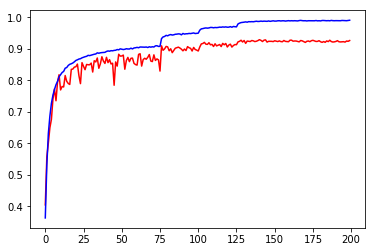

In [5]:
from matplotlib import pyplot
import numpy as np
%matplotlib inline
x=np.arange(200)
pyplot.plot(x,res["history"]['val_acc'], 'r', x, res["history"]['acc'], 'b')
